!mkdir content/
%cd content
!git clone https://github.com/VikasOjha666/Data-generator-for-CRNN.git
%cd Data-generator-for-CRNN
!mkdir images/
!python3 generate_data.py --n_samples 300000  

In [1]:
import fnmatch
import cv2
import numpy as np
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import os
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from collections import defaultdict


In [2]:
#char_list = string.ascii_letters+string.digits

punclist='.?:;"'
punclist2="-+/()[]!`,|*&^%$#@'"

#Character sets to choose from.
smallletters=string.ascii_lowercase
capitalletters=string.ascii_uppercase
digits=string.digits
char_list=smallletters+capitalletters+digits+punclist+punclist2

chars = defaultdict(int)
 
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

def find_dominant_color(image):
        #Resizing parameters
        width, height = 150,150
        image = image.resize((width, height),resample = 0)
        #Get colors from image object
        pixels = image.getcolors(width * height)
        #Sort them by count number(first element of tuple)
        sorted_pixels = sorted(pixels, key=lambda t: t[0])
        #Get the most frequent color
        dominant_color = sorted_pixels[-1][1]
        return dominant_color

def preprocess_img(img, imgSize):
    "put img into target img of size imgSize, transpose for TF and normalize gray-values"

    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = np.zeros([imgSize[1], imgSize[0]]) 
        print("Image None!")

    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1),
               max(min(ht, int(h / f)), 1))  # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(img, newSize, interpolation=cv2.INTER_CUBIC) # INTER_CUBIC interpolation best approximate the pixels image
                                                               # see this https://stackoverflow.com/a/57503843/7338066
    most_freq_pixel=find_dominant_color(Image.fromarray(img))
    target = np.ones([ht, wt]) * most_freq_pixel  
    target[0:newSize[1], 0:newSize[0]] = img

    img = target

    return img

def counting_characters(labels,chars):
    for label in labels:
        for char in label:
            chars[char] += 1
    return chars




In [3]:
print(char_list)
print(len(char_list))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.?:;"-+/()[]!`,|*&^%$#@'
86


In [4]:

training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
 
max_label_len = 0

annot=open('content/Data-generator-for-CRNN/annotation.txt','r').readlines()
imagenames=[]
txts=[]

for cnt in annot:

    filename,txt=cnt.split('~')[0],cnt.split('~')[1].split('\n')[0]
    imagenames.append(filename)
    txts.append(txt)
    
    #print(cnt.split('~')[0])
    #print(cnt.split('~')[1].split('\n')[0])
    #print()

chars=counting_characters(txts,chars)

c = list(zip(imagenames, txts))

random.shuffle(c)

imagenames, txts = zip(*c)
    

    
for i in range(len(imagenames)):
        img = cv2.imread('content/Data-generator-for-CRNN/images/'+imagenames[i],0)   
 
        img=preprocess_img(img,(128,32))
        img=np.expand_dims(img,axis=-1)
        img = img/255.
        txt = txts[i]
        
        # compute maximum length of the text
        if len(txt) > max_label_len:
            max_label_len = len(txt)
            
           
        # split the 150000 data into validation and training dataset as 10% and 90% respectively
        if i%10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt)) 
        
        # break the loop if total data is 200000
        if i == 200000:
            flag = 1
            break
        i+=1
        
    
    




In [5]:
print(len(imagenames))

200000


In [6]:
for x in char_list:
    print(x,": ",chars[x])
    

a :  24389
b :  24685
c :  24611
d :  24664
e :  24651
f :  24437
g :  24041
h :  24377
i :  24202
j :  24372
k :  24441
l :  24451
m :  24557
n :  24392
o :  24141
p :  24066
q :  24397
r :  24170
s :  24284
t :  24500
u :  24271
v :  24422
w :  24299
x :  24350
y :  24573
z :  24351
A :  24279
B :  24065
C :  24064
D :  24301
E :  24384
F :  24333
G :  24217
H :  24516
I :  24209
J :  24567
K :  24611
L :  24328
M :  24337
N :  24459
O :  24443
P :  24230
Q :  24382
R :  24503
S :  24287
T :  24596
U :  24276
V :  24617
W :  24118
X :  24233
Y :  24577
Z :  24402
0 :  24542
1 :  24581
2 :  24184
3 :  24419
4 :  24388
5 :  24391
6 :  24530
7 :  24344
8 :  24738
9 :  24277
. :  24384
? :  24209
: :  24388
; :  24437
" :  24634
- :  24490
+ :  24443
/ :  24239
( :  24197
) :  24361
[ :  24626
] :  24476
! :  24379
` :  24707
, :  24531
| :  24389
* :  24233
& :  24248
^ :  24436
% :  24435
$ :  24561
# :  24302
@ :  24380
' :  24507


In [7]:
#pad each output label to maximum text length
 
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [8]:
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.5))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.5))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

2022-05-23 20:24:26.866644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 20:24:26.898466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 20:24:26.898687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 20:24:26.899386: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [10]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [11]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50) 
 
    
filepath="all_rotated_1.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint,es]

In [12]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [13]:
batch_size = 256
epochs = 150
history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

2022-05-23 20:24:33.475449: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2949120000 exceeds 10% of free system memory.
2022-05-23 20:24:35.200899: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2949120000 exceeds 10% of free system memory.


Epoch 1/150


2022-05-23 20:24:40.544854: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-23 20:24:42.383619: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-23 20:24:44.073479: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


704/704 [==============================] - ETA: 0s - loss: 31.0594 - accuracy: 0.0171
Epoch 1: val_loss improved from inf to 109.87601, saving model to all_rotated_1.hdf5
704/704 [==============================] - 148s 195ms/step - loss: 31.0594 - accuracy: 0.0171 - val_loss: 109.8760 - val_accuracy: 0.0000e+00
Epoch 2/150
703/704 [============================>.] - ETA: 0s - loss: 3.8852 - accuracy: 0.3152
Epoch 2: val_loss improved from 109.87601 to 2.82419, saving model to all_rotated_1.hdf5
704/704 [==============================] - 133s 189ms/step - loss: 3.8851 - accuracy: 0.3152 - val_loss: 2.8242 - val_accuracy: 0.5235
Epoch 3/150
703/704 [============================>.] - ETA: 0s - loss: 2.0717 - accuracy: 0.5462
Epoch 3: val_loss did not improve from 2.82419
704/704 [==============================] - 134s 191ms/step - loss: 2.0719 - accuracy: 0.5462 - val_loss: 3.2586 - val_accuracy: 0.4933
Epoch 4/150
703/704 [============================>.] - ETA: 0s - loss: 1.5013 - accurac

704/704 [==============================] - 134s 190ms/step - loss: 0.3040 - accuracy: 0.8973 - val_loss: 0.8966 - val_accuracy: 0.8558
Epoch 29/150
703/704 [============================>.] - ETA: 0s - loss: 0.2767 - accuracy: 0.9041
Epoch 29: val_loss did not improve from 0.89324
704/704 [==============================] - 133s 190ms/step - loss: 0.2767 - accuracy: 0.9041 - val_loss: 0.9597 - val_accuracy: 0.8393
Epoch 30/150
703/704 [============================>.] - ETA: 0s - loss: 0.2770 - accuracy: 0.9052
Epoch 30: val_loss improved from 0.89324 to 0.88458, saving model to all_rotated_1.hdf5
704/704 [==============================] - 134s 191ms/step - loss: 0.2770 - accuracy: 0.9052 - val_loss: 0.8846 - val_accuracy: 0.8577
Epoch 31/150
703/704 [============================>.] - ETA: 0s - loss: 0.2724 - accuracy: 0.9057
Epoch 31: val_loss did not improve from 0.88458
704/704 [==============================] - 134s 190ms/step - loss: 0.2724 - accuracy: 0.9057 - val_loss: 0.9766 - val

704/704 [==============================] - 134s 191ms/step - loss: 0.1660 - accuracy: 0.9408 - val_loss: 1.1801 - val_accuracy: 0.8554
Epoch 58/150
703/704 [============================>.] - ETA: 0s - loss: 0.1664 - accuracy: 0.9411
Epoch 58: val_loss did not improve from 0.87759
704/704 [==============================] - 134s 191ms/step - loss: 0.1664 - accuracy: 0.9411 - val_loss: 1.0877 - val_accuracy: 0.8604
Epoch 59/150
703/704 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9404
Epoch 59: val_loss did not improve from 0.87759
704/704 [==============================] - 135s 191ms/step - loss: 0.1696 - accuracy: 0.9403 - val_loss: 0.9970 - val_accuracy: 0.8711
Epoch 60/150
703/704 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9412
Epoch 60: val_loss did not improve from 0.87759
704/704 [==============================] - 135s 191ms/step - loss: 0.1671 - accuracy: 0.9412 - val_loss: 1.0090 - val_accuracy: 0.8700
Epoch 61/150
703/704 [

In [14]:
# load the saved best model weights
act_model.load_weights('all_rotated_1.hdf5')
 
# predict outputs on validation images
prediction = act_model.predict(valid_img[10:20])
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
i = 10
for x in out:
    print("original_text = ", valid_orig_txt[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

original_text =  MAoWQ?/+#VX`8Lii
predicted text = MAoWQ?/+#VX`8Lii

original_text =  "]Bq%OsUJg|&;E2pNz
predicted text = "]Bq%OsUJg|&;E2pNz

original_text =  Ytk?-;:F/
predicted text = Ytk?-;:F/

original_text =  awDu'
predicted text = awDu'

original_text =  6p2]']/H+W).Y'jK-
predicted text = 6p2]']/H+W).Y'jK-

original_text =  c9toP%
predicted text = c9toP%

original_text =  GN]4$)!]D-t#
predicted text = GN]4$)!]D-t#

original_text =  "/e6A/6;N
predicted text = "/e6A/6;N

original_text =  RR
predicted text = RR

original_text =  O4EK,1w
predicted text = O4EK,1w



<function matplotlib.pyplot.show(close=None, block=None)>

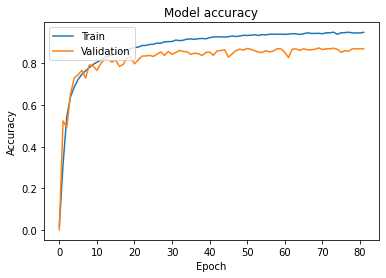

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.savefig('all_rotated1.png')
plt.show